# GP classification example with typical toy datasets

In [1]:
import math
import numpy as np

import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from collections import OrderedDict

from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Make the datasets

Moons               X : (100, 2) 	 y : (100,)
Circles             X : (100, 2) 	 y : (100,)
Gaussians           X : (200, 2) 	 y : (200,)


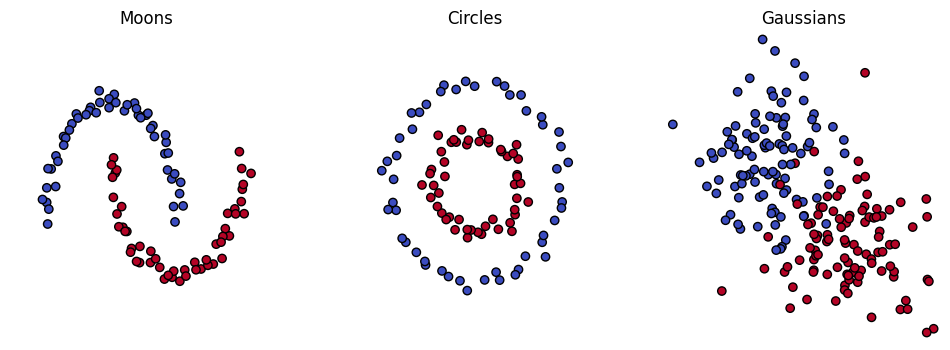

In [2]:
n_samples = 100
n_features = 2
n_classes = 2
noise = 0.05
random_state = 42

panel_width = 4
panel_height = 4

datasets = OrderedDict([('Moons', make_moons(n_samples=n_samples, noise=noise, random_state=random_state)),
                        ('Circles', make_circles(n_samples=n_samples, noise=noise, random_state=random_state, factor=0.5)),
                        # ('Gaussians', make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_features, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, random_state=random_state)),
                        ('Gaussians', make_blobs(n_samples=(n_samples,)*n_classes, n_features=n_features, centers=None, cluster_std=3.0, center_box=(-8.0, 8.0), shuffle=True, random_state=random_state, return_centers=False))
                        ]
                    )

fig = plt.figure(figsize=(panel_width*len(datasets), panel_height))

i = 1
for ds_name, ds in datasets.items():
    print(f'{ds_name:20}X : {ds[0].shape} \t y : {ds[1].shape}')

    x_min, x_max = ds[0][:,0].min() - 0.5, ds[0][:,0].max() + 0.5
    y_min, y_max = ds[0][:,1].min() - 0.5, ds[0][:,1].max() + 0.5

    ax = plt.subplot(1, len(datasets), i)

    # ax = sns.scatterplot(x=ds[0][:,0], y=ds[0][:,1], hue=ds[1])
    # ax.get_legend().set_visible(False)
    ax.scatter(ds[0][:,0], ds[0][:,1], c=ds[1], cmap=plt.cm.coolwarm, edgecolors="k")

    ax.set_title(ds_name)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True, offset=10, trim=True)

    i = i + 1

plt.show()

### Define the GP classifiers and instantiate them with appropriate datasets and splits

In [3]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_function, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            kernel_function(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
        # self.covar_module = kernel_function(batch_shape=torch.Size((num_classes,)))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# # initialize likelihood and model
# # we let the DirichletClassificationLikelihood compute the targets for us
# likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
# model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    
kernel_functions = [LinearKernel, RBFKernel]

Moons               X : (100, 2) 	 y : (100,)
GP model with LinearKernel
Iter :    5/ 100	Loss: 5.6857
Iter :   10/ 100	Loss: 5.2174
Iter :   15/ 100	Loss: 4.9218
Iter :   20/ 100	Loss: 4.7428
Iter :   25/ 100	Loss: 4.6375
Iter :   30/ 100	Loss: 4.577
Iter :   35/ 100	Loss: 4.5423
Iter :   40/ 100	Loss: 4.5221
Iter :   45/ 100	Loss: 4.5098
Iter :   50/ 100	Loss: 4.502
Iter :   55/ 100	Loss: 4.497
Iter :   60/ 100	Loss: 4.4939
Iter :   65/ 100	Loss: 4.4922
Iter :   70/ 100	Loss: 4.4913
Iter :   75/ 100	Loss: 4.4908
Iter :   80/ 100	Loss: 4.4907
Iter :   85/ 100	Loss: 4.4906
Iter :   90/ 100	Loss: 4.4906
Iter :   95/ 100	Loss: 4.4906
Iter :  100/ 100	Loss: 4.4906


/Users/msa/anaconda3/envs/mygpytorch/lib/python3.11/site-packages/gpytorch-0.0.0-py3.11.egg/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


RuntimeError: Expected b and A to have the same dtype, but found b of type Float and A of type Double instead.

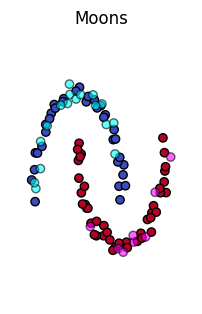

In [22]:
test_set_ratio = 0.25
n_iter = 100

fig = plt.figure(figsize=(panel_height*len(kernel_functions), panel_width*len(datasets)))

i = 1
for ds_name, ds in datasets.items():
    print(f'{ds_name:20}X : {ds[0].shape} \t y : {ds[1].shape}')

    x_min, x_max = ds[0][:,0].min() - 0.5, ds[0][:,0].max() + 0.5
    y_min, y_max = ds[0][:,1].min() - 0.5, ds[0][:,1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step=0.02), np.arange(y_min, y_max, step=0.02))

    X_train, X_test, y_train, y_test = train_test_split(ds[0], ds[1], test_size=test_set_ratio, random_state=random_state)
    X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

    ax = plt.subplot(len(datasets), len(kernel_functions) + 1, (i-1)*(len(kernel_functions) + 1) + 1)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm, edgecolors="k")
    ax.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.cool, alpha=0.6, edgecolors="k")

    ax.set_title(ds_name)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True, offset=10, trim=True)
    
    for kernel_function in kernel_functions:

        print(f'GP model with {kernel_function.__name__}')

        likelihood = DirichletClassificationLikelihood(y_train, learn_additional_noise=True) 
        model = DirichletGPModel(X_train, likelihood.transformed_targets, likelihood, kernel_function, num_classes=likelihood.num_classes)    ### WHAT HAPPENS if use the actual labels here??????????? Need to test!!
        # model = DirichletGPModel(X_train, y_train, likelihood, num_classes=n_classes)

        # print(f'Parameters of the GP model:')
        # for param_name, param in model.named_parameters():
        #     print(f'{param_name:50}') # value = {param.item():20}')

        optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)  # Includes the likelihood parameters
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        model.train()
        likelihood.train()

        for iter in range(n_iter):

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            # Output from model
            output = model(X_train)

            # Calc loss and backprop gradients
            loss = -mll(output, likelihood.transformed_targets).sum()
            loss.backward()

            if (iter+1) % 5 == 0:
                print(f'Iter : {iter+1:4}/{n_iter:4}\tLoss: {loss.item():5.5}')

            optimizer.step()
        

        model.eval()
        likelihood.eval()
        
        with torch.no_grad(): #, gpytorch.settings.fast_pred_var():

            f_preds = model(X_train)
            y_preds = f_preds.loc

            # print(f'Training accuracy : {np.mean(((y_train.item() == y_preds.item())))}')

            # f_preds = model(X_test)
            # y_preds = f_preds.loc

            # print(f'Training accuracy : {np.mean(((y_test.item() == y_preds.item())))}')

            # f_preds = model(np.column_stack([xx.ravel(), yy.ravel()]))
            # y_preds = f_preds.loc
        
    
    i = i + 1

# plt.tight_layout()
plt.show()
